# Define Required Libraries and The Dataset

In [ ]:
pip install gdown


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import os
from gensim.models import KeyedVectors
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Read CSV file into pandas DataFrame
df_train = pd.read_csv('train.csv')
df_dev = pd.read_csv('dev.csv')
df_test = pd.read_csv('test.csv')

# Display the first few rows of the DataFrame
print('dev shape: ', df_dev.shape)
print('test shape: ', df_test.shape)
print('train shape: ', df_train.shape)
print(df_train['sentiment'].value_counts())
print(df_dev['sentiment'].value_counts())
print(df_test['sentiment'].value_counts())

dev shape:  (400, 2)
test shape:  (400, 2)
train shape:  (1477, 2)
sentiment
positive    823
negative    654
Name: count, dtype: int64
sentiment
positive    232
negative    168
Name: count, dtype: int64
sentiment
positive    203
negative    197
Name: count, dtype: int64


.

.

# Data Preprocessing

**Step 1: Load pre-trained embeddings.** Use a glove pre-trained “glove.6B.50d.word2vec.txt” to obtain a representation of the tweets (you can use load it is using libraries such as genism)

In [ ]:
word_embeddings = {}

# Opens the file glove.6B.50d.txt in read mode

with open('glove.6B.50d.txt', 'r', encoding='utf-8') as f:
  for line in f: # for every line wich has the word and its representation
    values = line.split()
    word = values[0] #take the word
    vector = np.asarray(values[1:], dtype='float32')  # Convert string values to float
    word_embeddings[word] = vector  # Map the word to its embedding , word is the key and its representation is the vector



**Step 2: Get a Representation for Each Review:**

1. Retrieve Word Embeddings: For each word in a review, retrieve its corresponding embedding from the pre-trained GloVe model (50-dimensional). If a word is not present in the pre-trained vocabulary, use a default vector (e.g., a 50-dimensional zero vector).

2. Aggregate Embeddings for the Review: For each review, compute a single fixed-length vector by taking the mean of the embeddings of all its words.
This process converts each review into a 50-dimensional vector that serves as input to the logistic regression model.

In [ ]:
def get_embedding_word(word):
  # Define the default embedding for unknown words (zero vector)
  # Return the word embedding if found, otherwise return the default vector
  # from array word_embeddings
  return word_embeddings.get(word, np.zeros(50, dtype='float32'))


In [ ]:
import numpy as np
import pandas as pd

def get_embedding_review(df):
  # Create a new column for storing the embedding sum/average for each review
  embedding_reviews = []

  for review in df['review']:

      sum_all_the_review = 0
      word_count = 0

      words = review.split()

      for word in words:
          embedding_representation = get_embedding_word(word)
          word_embedding_sum = np.sum(embedding_representation)  # Sum the components of the embedding
          sum_all_the_review += word_embedding_sum
          word_count += 1

      # Compute the average word embedding sum for the review (handle empty reviews)
      if word_count > 0:
          embedding_reviews.append(sum_all_the_review / word_count)
      else:
          embedding_reviews.append(0)  # Handle case where review is empty (no words)

  # Add the computed embedding averages as a new column to the DataFrame
  return embedding_reviews

In [ ]:
df_train['embedding review'] = get_embedding_review(df_train)
df_dev['embedding review'] = get_embedding_review(df_dev)
df_test['embedding review'] = get_embedding_review(df_test)

In [ ]:
df_train.head()


,review,sentiment,embedding review
0,This movie was so predictable and poorly acted...,negative,1.384566
1,"Now, I am not prone to much emotion, but I cri...",positive,1.352929
2,Here in Brazil is very rare to see a good Braz...,positive,1.239449
3,Summer Phoenix did a great performance where y...,positive,1.188180
4,Brilliant and moving performances by Tom Court...,positive,-0.218288



.

.

**Step 3: Feature Normalization (pts):** normalize the features so that they have similar scales, which is crucial for the gradient descent optimization in logistic regression.

* apply min-max normalization to scale all feature values between 0 and 1.
* Calculate the minimum and maximum values of each feature only from the training set. Use these values to normalize both the training set and later the test and dev sets.
* Create a separate function to perform this task.

In [ ]:
train_min = df_train['embedding review'].min()
train_max = df_train['embedding review'].max()
print(train_min, train_max)

-1.1382770140965779 2.998200386762619


In [ ]:
def normalize_features(df):
  df['sentiment_encoded'] = df['sentiment'].map({'positive': 1, 'negative': 0})
  df['embedding review'] = (df['embedding review'] - train_min) / (train_max - train_min)
  return df

df_train = normalize_features(df_train)
df_dev = normalize_features(df_dev)
df_test = normalize_features(df_test)

In [ ]:
df_train.head()

,review,sentiment,embedding review,sentiment_encoded
0,This movie was so predictable and poorly acted...,negative,0.609901,0
1,"Now, I am not prone to much emotion, but I cri...",positive,0.602253,1
2,Here in Brazil is very rare to see a good Braz...,positive,0.574819,1
3,Summer Phoenix did a great performance where y...,positive,0.562425,1
4,Brilliant and moving performances by Tom Court...,positive,0.222409,1


...

**Show the relation between the Review and Sentiment**

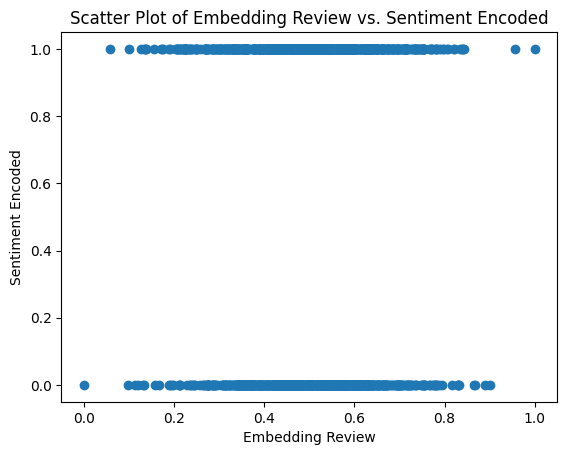

In [ ]:
plt.scatter(df_train['embedding review'], df_train['sentiment_encoded'])
plt.xlabel('Embedding Review')
plt.ylabel('Sentiment Encoded')
plt.title('Scatter Plot of Embedding Review vs. Sentiment Encoded')
plt.show()

# lr implementation

## Explanation

linear regression formula

**𝑦 = 𝛽₀ + 𝛽₁𝑥₁ + ⋯ + 𝛽ᵣ𝑥ᵣ** ,
where **𝛽₀, 𝛽₁, …, 𝛽ᵣ** are the regression coefficients.

The goal is to: calculate the optimal values of the predicted weights of coefficients that minimize the error and determine the estimated regression function.



---



The cost function

* measures the difference between the predicted values of the model and the actual target values.
* By minimizing this cost function, we can: determine the optimal values for the model’s parameters and improve its performance.


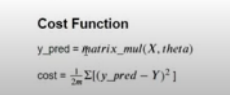



---



The Gradient Descent

* The main aim is to find the best parameters of a model which gives the highest accuracy on training as well as testing datasets.

* It is **a vector that points**, works by **moving downward toward** the pits or valleys in the graph to find the minimum value. This is achieved by taking the derivative of the cost function.

* By adjusting the parameters in this direction, it seeks to reach the minimum of the cost function and find the best-fit values for the parameters. The size of each step is determined by parameter **α** known as **Learning Rate.**

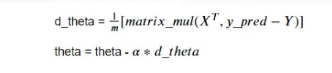



---



**Types of Gradient Descent**

1. **Batch Gradient Descent**

* uses the entire dataset to calculate the gradient and update the parameters once per epoch.

2. **Stochastic Gradient Descent**
* updates the parameters for each data point, using only one example at a time. This allows SGD to make quick progress since it doesn’t wait for all data points
*  it may result in more fluctuations progress toward the minimum

3. **Mini-batch Gradient Descent**
* is a middle ground between batch and stochastic gradient descent.
*  Instead of using the whole dataset or a single point, it divides the data into small batches (e.g., 32 or 64 points) and calculates gradients for each batch.

---

**Epoch** is the complete passing through of all the datasets exactly at once.

Since a single epoch is too large to be sent to the computer at once, it is divided into smaller **batches.**

**Batch size** is the total number of training instances inside a particular batch.

**Iterations** refer to the number of batches required to complete one epoch.




---



X = np.hstack((np.ones((X.shape[0], 1)), X)) it is ok if I add a column of 0's instead of ones here
ChatGPT said:
ChatGPT
No, adding a column of 0's instead of 1's as the bias term is not correct. Here's why:

Purpose of Adding a Bias Term
The bias term (column of 1's) in linear regression allows the model to learn an intercept (𝜃0) in the equation of the form:



---



When you're asked to "report your observation on **the convergence behavior of the gradient descent**," the goal is to analyze and describe how the gradient descent algorithm progresses during training, particularly how it minimizes the cost function over time.




---



## THE MODEL

* Use a fixed number of iterations (1000) as your stopping condition.

In [ ]:
def accuracy(y, y_pred):
    predictions = [1 if pred >= 0.5 else 0 for pred in y_pred]
    return np.sum(predictions == y) / len(y)

In [ ]:
def LR_model (X, Y, learning_rate, num_iterations = 1000, batch_size=32):

  m = Y.size # Number of samples in the dataset
  theta = np.zeros((2,1))  # Initialize weights (including bias) to zero

  X =X.values.reshape(-1, 1)  #  ensures X becomes a 2D array with shape (1477, 1) instead of a 1D array.
  X = np.hstack((np.ones((X.shape[0], 1)), X)) # Add bias column (shape: (m, 2))
  Y = Y.values.reshape(-1, 1)


  cost = [] # List to store cost values
  max_acc = -1e9 # Initialize maximum accuracy
  acc = []  # List to store accuracy values

  for i in range(num_iterations):

    # Shuffle the data at the start of each epoch
    indices = np.arange(m)
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]

    for start in range(0, m, batch_size):
      end = start + batch_size
      X_batch = X[start:end]  # Current batch of features
      Y_batch = Y[start:end]  # Current batch of targets


      # Predicts the target values for the current batch using the current weights theta
      y_pred = np.dot(X_batch, theta)
      current_acc = accuracy(Y_batch, y_pred)  # Calculate accuracy for the current batch
      max_acc = max(max_acc, current_acc)


      # Compute the cost &  the gradient
      cost.append( (1 / (2 * batch_size)) * np.sum(np.square(y_pred - Y_batch)))
      d_theta = (1 / batch_size) * np.dot(X_batch.T, (y_pred - Y_batch))

      # Update weights
      theta = theta - learning_rate * d_theta

    # Log cost, accuracy every 100 iterations
    if i % 100 == 0:
      total_cost = (1 / (2 * m)) * np.sum(np.square(np.dot(X, theta) - Y))
      print(f"Iteration {i}: Cost = {total_cost}")
      cost.append(total_cost)
      acc.append(current_acc)

  # Append the final loss
  final_cost = (1 / (2 * m)) * np.sum(np.square(np.dot(X, theta) - Y))
  cost.append(final_cost)

  return theta, acc, max_acc

## Q1.

 * The behavior of Gradient descent can be strongly influenced by the learning rate (𝜂).




---



1. Experiment with different learning rates (10000, 1000, 100, 10, 1, .01, .001, .0001, .00001)
* REPORT your observation on **the convergence behavior of the gradient descent.**
*  MENTION your choice clearly in your report. Note that if you observe an overflow, then the learning rate you are using is too big. Please MENTION the learning rates that cause an overflow.
* REPORT the training and dev accuracy for each learning rate value in a table, which one are you going to use for the final model?


In [ ]:
X = df_train['embedding review']
Y = df_train['sentiment_encoded']

X_Eval = df_dev['embedding review']
Y_Eval = df_dev['sentiment_encoded']

X_test = df_test['embedding review']
Y_test = df_test['sentiment_encoded']

### LR = 10000

In [ ]:
learning_rate = 10000
theta, acc1, max_acc10000 = LR_model(X, Y, learning_rate)
print(theta)

<ipython-input-17-17d112449eab>:36: RuntimeWarning: overflow encountered in square
  cost.append( (1 / (2 * batch_size)) * np.sum(np.square(y_pred - Y_batch)) )
<ipython-input-17-17d112449eab>:44: RuntimeWarning: overflow encountered in square
  total_cost = (1 / (2 * m)) * np.sum(np.square(np.dot(X, theta) - Y))
<ipython-input-17-17d112449eab>:40: RuntimeWarning: overflow encountered in multiply
  theta = theta - learning_rate * d_theta
<ipython-input-17-17d112449eab>:40: RuntimeWarning: invalid value encountered in subtract
  theta = theta - learning_rate * d_theta


Iteration 0: Cost = inf
Iteration 100: Cost = nan
Iteration 200: Cost = nan
Iteration 300: Cost = nan
Iteration 400: Cost = nan
Iteration 500: Cost = nan
Iteration 600: Cost = nan
Iteration 700: Cost = nan
Iteration 800: Cost = nan
Iteration 900: Cost = nan
[[nan]
 [nan]]


### LR = 1000

In [ ]:
learning_rate = 1000
theta, acc2, max_acc1000 = LR_model(X, Y, learning_rate)
print(theta)

Iteration 0: Cost = 4.2666097536982364e+288


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
<ipython-input-17-17d112449eab>:36: RuntimeWarning: overflow encountered in square
  cost.append( (1 / (2 * batch_size)) * np.sum(np.square(y_pred - Y_batch)) )
<ipython-input-17-17d112449eab>:40: RuntimeWarning: invalid value encountered in subtract
  theta = theta - learning_rate * d_theta


Iteration 100: Cost = nan
Iteration 200: Cost = nan
Iteration 300: Cost = nan
Iteration 400: Cost = nan
Iteration 500: Cost = nan
Iteration 600: Cost = nan
Iteration 700: Cost = nan
Iteration 800: Cost = nan
Iteration 900: Cost = nan
[[nan]
 [nan]]


### LR = 100

In [ ]:
learning_rate = 100
theta, acc3, max_acc100 = LR_model(X, Y, learning_rate)
print(theta)

Iteration 0: Cost = 4.0000153347011814e+194


<ipython-input-17-17d112449eab>:36: RuntimeWarning: overflow encountered in square
  cost.append( (1 / (2 * batch_size)) * np.sum(np.square(y_pred - Y_batch)) )
<ipython-input-17-17d112449eab>:40: RuntimeWarning: invalid value encountered in subtract
  theta = theta - learning_rate * d_theta


Iteration 100: Cost = nan
Iteration 200: Cost = nan
Iteration 300: Cost = nan
Iteration 400: Cost = nan
Iteration 500: Cost = nan
Iteration 600: Cost = nan
Iteration 700: Cost = nan
Iteration 800: Cost = nan
Iteration 900: Cost = nan
[[nan]
 [nan]]


In [ ]:
learning_rate = 100
theta, acc_eval1, max_eval_acc100 = LR_model(X_Eval, Y_Eval, learning_rate)
print(theta)

Iteration 0: Cost = 9.709525555501637e+52
Iteration 100: Cost = nan


<ipython-input-17-17d112449eab>:36: RuntimeWarning: overflow encountered in square
  cost.append( (1 / (2 * batch_size)) * np.sum(np.square(y_pred - Y_batch)) )
<ipython-input-17-17d112449eab>:40: RuntimeWarning: overflow encountered in multiply
  theta = theta - learning_rate * d_theta
<ipython-input-17-17d112449eab>:40: RuntimeWarning: invalid value encountered in subtract
  theta = theta - learning_rate * d_theta


Iteration 200: Cost = nan
Iteration 300: Cost = nan
Iteration 400: Cost = nan
Iteration 500: Cost = nan
Iteration 600: Cost = nan
Iteration 700: Cost = nan
Iteration 800: Cost = nan
Iteration 900: Cost = nan
[[nan]
 [nan]]


### LR = 10

---

In [ ]:
learning_rate = 10
theta, acc4, max_acc10 = LR_model(X, Y, learning_rate)
print(theta)

Iteration 0: Cost = 4.076940647309801e+96


<ipython-input-17-17d112449eab>:36: RuntimeWarning: overflow encountered in square
  cost.append( (1 / (2 * batch_size)) * np.sum(np.square(y_pred - Y_batch)) )
<ipython-input-17-17d112449eab>:40: RuntimeWarning: invalid value encountered in subtract
  theta = theta - learning_rate * d_theta


Iteration 100: Cost = nan
Iteration 200: Cost = nan
Iteration 300: Cost = nan
Iteration 400: Cost = nan
Iteration 500: Cost = nan
Iteration 600: Cost = nan
Iteration 700: Cost = nan
Iteration 800: Cost = nan
Iteration 900: Cost = nan
[[nan]
 [nan]]


### LR = 1

In [ ]:
learning_rate = 1
theta, acc5, max_acc1 = LR_model(X, Y, learning_rate)
print(theta)
print(max_acc1)

Iteration 0: Cost = 0.1265436438196758
Iteration 100: Cost = 0.13047862871679045
Iteration 200: Cost = 0.12799566069705373
Iteration 300: Cost = 0.1283941097022873
Iteration 400: Cost = 0.12448267102822903
Iteration 500: Cost = 0.12386169438869059
Iteration 600: Cost = 0.12827170313862987
Iteration 700: Cost = 0.12449489994604329
Iteration 800: Cost = 0.12524231731199498
Iteration 900: Cost = 0.12443795156369056
[[ 0.48245534]
 [-0.12110015]]
28.0


In [ ]:
theta, accEval1, max_eval_acc1 = LR_model(X_Eval, Y_Eval, learning_rate)
print(theta)
print(max_acc1)

Iteration 0: Cost = 0.12494316073630717
Iteration 100: Cost = 0.12392808897085261
Iteration 200: Cost = 0.12217501931053151
Iteration 300: Cost = 0.12196478716420325
Iteration 400: Cost = 0.1398693343204011
Iteration 500: Cost = 0.1261157859342475
Iteration 600: Cost = 0.12207295783148794
Iteration 700: Cost = 0.12835271420903033
Iteration 800: Cost = 0.12758530744684074
Iteration 900: Cost = 0.12711762212137281
[[ 0.40258503]
 [-0.07710815]]
28.0


### LR = 0.01

In [ ]:
learning_rate = .01
theta, acc6, max_acc01 = LR_model(X, Y, learning_rate)
print(theta)

Iteration 0: Cost = 0.17262339634980725
Iteration 100: Cost = 0.12350686742375706
Iteration 200: Cost = 0.12334133387261356
Iteration 300: Cost = 0.12330485628857724
Iteration 400: Cost = 0.12329675794394294
Iteration 500: Cost = 0.12329391670342175
Iteration 600: Cost = 0.12329400536434829
Iteration 700: Cost = 0.1232938370463008
Iteration 800: Cost = 0.12329336220951724
Iteration 900: Cost = 0.12329411523190455
[[ 0.59809639]
 [-0.08326588]]


In [ ]:
learning_rate = .01
theta, accEval01,max_eval_acc01 = LR_model(X_Eval, Y_Eval, learning_rate)
print(theta)

Iteration 0: Cost = 0.24428151627325598
Iteration 100: Cost = 0.12212632657153563
Iteration 200: Cost = 0.12201239084321726
Iteration 300: Cost = 0.12193764845394818
Iteration 400: Cost = 0.1218887247182051
Iteration 500: Cost = 0.12185668419507263
Iteration 600: Cost = 0.12183566216112418
Iteration 700: Cost = 0.12182198642675073
Iteration 800: Cost = 0.12181296483836974
Iteration 900: Cost = 0.1218070886955337
[[0.55712875]
 [0.04609776]]


### LR = 0.001

In [ ]:
learning_rate = .001
theta, acc7, max_acc001 = LR_model(X, Y, learning_rate)
print(theta)

Iteration 0: Cost = 0.2617436617284719
Iteration 100: Cost = 0.12412284527959934
Iteration 200: Cost = 0.1240067057546265
Iteration 300: Cost = 0.12390778077493925
Iteration 400: Cost = 0.12382257454914604
Iteration 500: Cost = 0.12374918423665117
Iteration 600: Cost = 0.12368596937343324
Iteration 700: Cost = 0.12363152284424017
Iteration 800: Cost = 0.12358462441632855
Iteration 900: Cost = 0.12354423149724492
[[0.52471772]
 [0.06271015]]


In [ ]:
learning_rate = .001
theta, accEval001, max_eval_acc001 = LR_model(X_Eval, Y_Eval, learning_rate)
print(theta)

Iteration 0: Cost = 0.28478354274916584
Iteration 100: Cost = 0.12917157184713787
Iteration 200: Cost = 0.12255318751548902
Iteration 300: Cost = 0.12225412033059688
Iteration 400: Cost = 0.12222383604251535
Iteration 500: Cost = 0.12220561258911705
Iteration 600: Cost = 0.1221886119572255
Iteration 700: Cost = 0.12217233389339323
Iteration 800: Cost = 0.12215673174539708
Iteration 900: Cost = 0.12214177612515097
[[0.47903474]
 [0.19540021]]


### LR = 0.0001

In [ ]:
learning_rate = 0.0001
theta, acc8, max_acc0001 = LR_model(X, Y, learning_rate)
print(theta)

Iteration 0: Cost = 0.27682948439024424
Iteration 100: Cost = 0.17221346501739462
Iteration 200: Cost = 0.13931102437731116
Iteration 300: Cost = 0.1289564804441797
Iteration 400: Cost = 0.12569141798296735
Iteration 500: Cost = 0.12465576051721046
Iteration 600: Cost = 0.12432111115356392
Iteration 700: Cost = 0.12420702786679387
Iteration 800: Cost = 0.1241623982196395
Iteration 900: Cost = 0.12413974287243641
[[0.45245025]
 [0.20174398]]


In [ ]:
learning_rate = .0001

theta,accEval0001, max_eval_acc0001 = LR_model(X_Eval, Y_Eval, learning_rate, 10000)
print(theta)

Iteration 0: Cost = 0.28947113717897743
Iteration 100: Cost = 0.24419360064740508
Iteration 200: Cost = 0.21117829065931026
Iteration 300: Cost = 0.18710410500912328
Iteration 400: Cost = 0.16954945281247322
Iteration 500: Cost = 0.15674874237728723
Iteration 600: Cost = 0.14741439922415148
Iteration 700: Cost = 0.14060758914560967
Iteration 800: Cost = 0.13564379036552315
Iteration 900: Cost = 0.13202379810750128
Iteration 1000: Cost = 0.12938366784064323
Iteration 1100: Cost = 0.12745808657099392
Iteration 1200: Cost = 0.12605344459745774
Iteration 1300: Cost = 0.1250286997121786
Iteration 1400: Cost = 0.12428092047285523
Iteration 1500: Cost = 0.12373515563609923
Iteration 1600: Cost = 0.12333665611066763
Iteration 1700: Cost = 0.1230455428545103
Iteration 1800: Cost = 0.122832745046922
Iteration 1900: Cost = 0.12267704853377692
Iteration 2000: Cost = 0.122562999601386
Iteration 2100: Cost = 0.12247931492175151
Iteration 2200: Cost = 0.12241776300620479
Iteration 2300: Cost = 0.1223

### LR = 0.00001

In [ ]:
learning_rate = .00001
Best_theta,acc9, max_acc00001 = LR_model(X, Y, learning_rate)
print(Best_theta)

Iteration 0: Cost = 0.2784267940586307
Iteration 100: Cost = 0.2615815972083068
Iteration 200: Cost = 0.24657665531088516
Iteration 300: Cost = 0.2332109059498282
Iteration 400: Cost = 0.2213052660899882
Iteration 500: Cost = 0.21070020996692032
Iteration 600: Cost = 0.20125364752528077
Iteration 700: Cost = 0.19283900554657407
Iteration 800: Cost = 0.18534354916110388
Iteration 900: Cost = 0.17866685300984742
[[0.19556432]
 [0.09635354]]


In [ ]:
learning_rate = .00001
theta ,accEval00001, max_eval_acc00001= LR_model(X_Eval, Y_Eval, learning_rate)
print(theta)

Iteration 0: Cost = 0.28994704065542065
Iteration 100: Cost = 0.28473467932878493
Iteration 200: Cost = 0.27968436563333365
Iteration 300: Cost = 0.27479106174398615
Iteration 400: Cost = 0.2700498886596135
Iteration 500: Cost = 0.26545611265604024
Iteration 600: Cost = 0.26100515091419874
Iteration 700: Cost = 0.25669256369282956
Iteration 800: Cost = 0.2525140520633196
Iteration 900: Cost = 0.24846544600090484
[[0.06708321]
 [0.0341386 ]]


### Iterations = 10000, LR = 0.0001

* Notice that the smaller the learning rate you use, the more the number of iterations you need. Try to use 10000 iterations for the learning rate 0.0001, do you observe any Accuracy improvement?

In [ ]:
learning_rate = .0001
theta ,acc, max_acc = LR_model(X, Y, learning_rate,10000)
print(theta)
print (acc, max_acc)

Iteration 0: Cost = 0.27682951563964975
Iteration 100: Cost = 0.17222416381313663
Iteration 200: Cost = 0.13932646958914544
Iteration 300: Cost = 0.12896942905366285
Iteration 400: Cost = 0.12569929589523446
Iteration 500: Cost = 0.12465874973709612
Iteration 600: Cost = 0.1243202253149717
Iteration 700: Cost = 0.1242031478468032
Iteration 800: Cost = 0.12415623319675965
Iteration 900: Cost = 0.12413173481781503
Iteration 1000: Cost = 0.12411456183258124
Iteration 1100: Cost = 0.12409991364243902
Iteration 1200: Cost = 0.12408624651036039
Iteration 1300: Cost = 0.12407306114862171
Iteration 1400: Cost = 0.1240601858262526
Iteration 1500: Cost = 0.12404756181891208
Iteration 1600: Cost = 0.12403516332142565
Iteration 1700: Cost = 0.12402297953956812
Iteration 1800: Cost = 0.12401100276175553
Iteration 1900: Cost = 0.12399922800686582
Iteration 2000: Cost = 0.12398765133248499
Iteration 2100: Cost = 0.12397626917899054
Iteration 2200: Cost = 0.12396507768493333
Iteration 2300: Cost = 0.1

## Q2.

Plot:
* **the training accuracy**,
* **the validation accuracy**

of your model as a function of the number of gradient descent iterations for each learning rate of the three learning rates: 100, 0.1, 0.001 .00001.
The **y-axis** is the **accuracy**, the **x-axis** is the **number of iterations.**
What have you observed? Explain your observations.

---

In [ ]:
def plot_accuracy(acc, learning_rate, str):
  # Generate x-axis values corresponding to the iterations where loss was logged
  iterations = [i for i in range(100, 1001, 100)]  # Every 100th iteration, plus final

  plt.plot(iterations, acc, marker='o', label='Training')
  plt.title(str + ' Accuracy over Iterations')
  plt.xlabel('Iterations')
  plt.ylabel('Average')
  plt.grid(True)
  plt.legend()
  plt.show()

### LR = 100



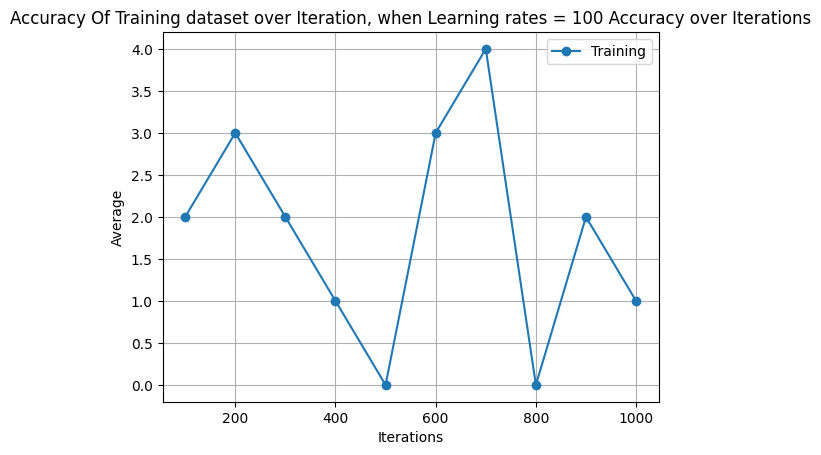

In [ ]:
plot_accuracy(acc3, 100, 'Accuracy Of Training dataset over Iteration, when Learning rates = 100')

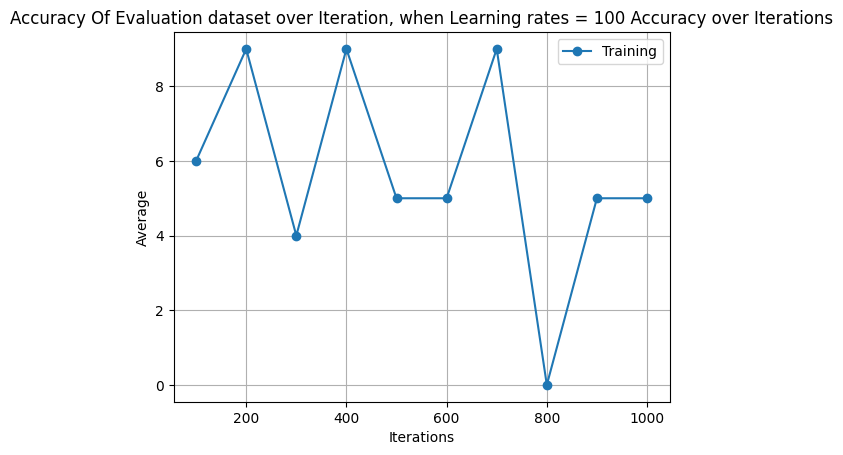

In [ ]:
plot_accuracy(acc_eval1, 100, 'Accuracy Of Evaluation dataset over Iteration, when Learning rates = 100')

### LR = 0.01

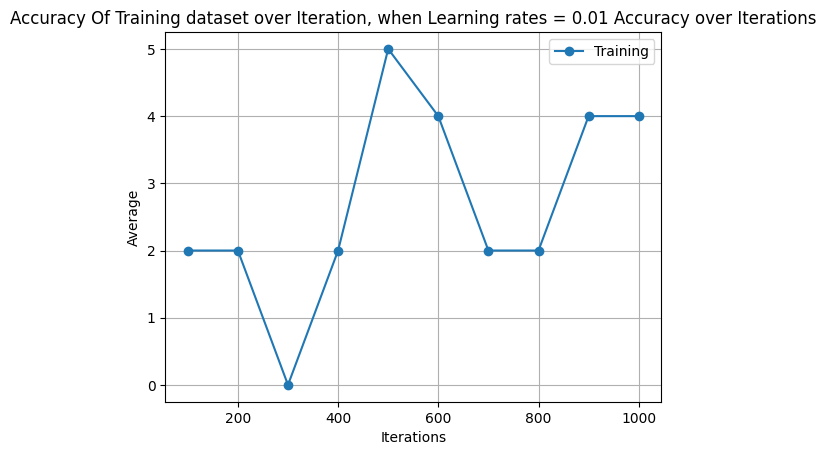

In [ ]:
plot_accuracy(acc6, 0.01, 'Accuracy Of Training dataset over Iteration, when Learning rates = 0.01')

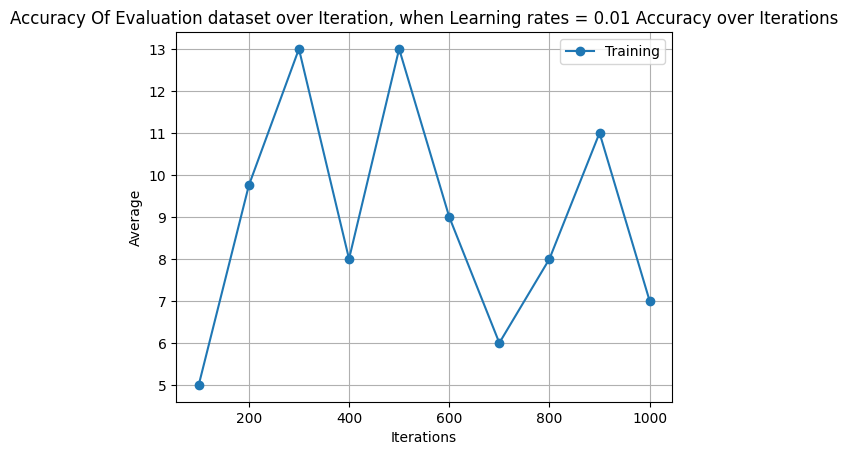

In [ ]:
plot_accuracy(accEval01, 0.01, 'Accuracy Of Evaluation dataset over Iteration, when Learning rates = 0.01')

### LR = 0.001

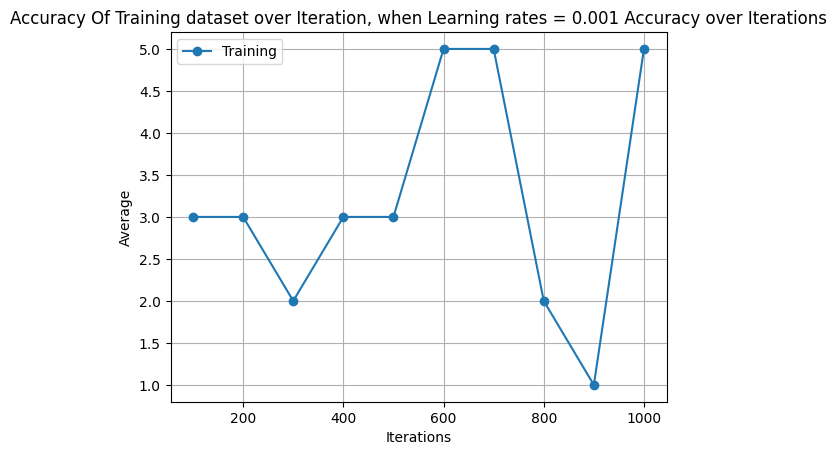

In [ ]:
plot_accuracy(acc7, 0.001, 'Accuracy Of Training dataset over Iteration, when Learning rates = 0.001')

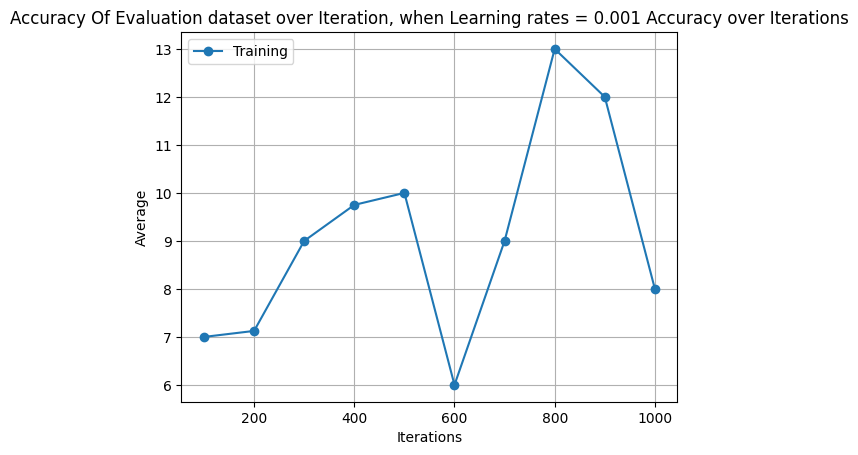

In [ ]:
plot_accuracy(accEval001, 0.001, 'Accuracy Of Evaluation dataset over Iteration, when Learning rates = 0.001')

### LR = 0.00001

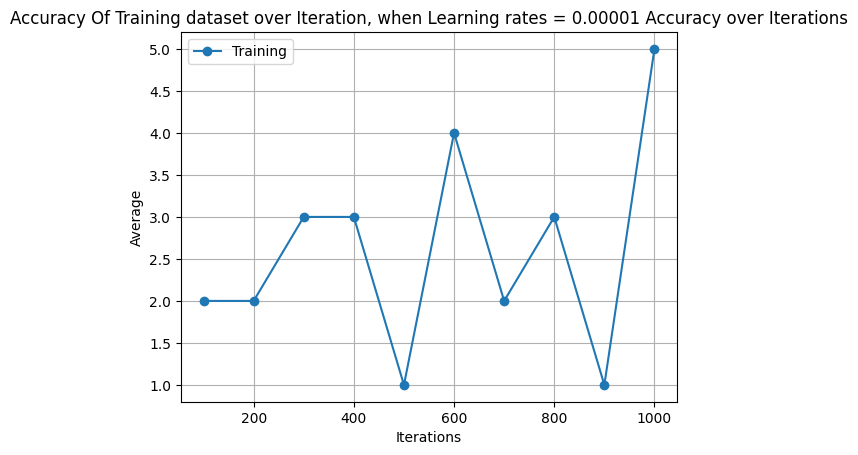

In [ ]:
plot_accuracy(acc9, 0.00001, 'Accuracy Of Training dataset over Iteration, when Learning rates = 0.00001')

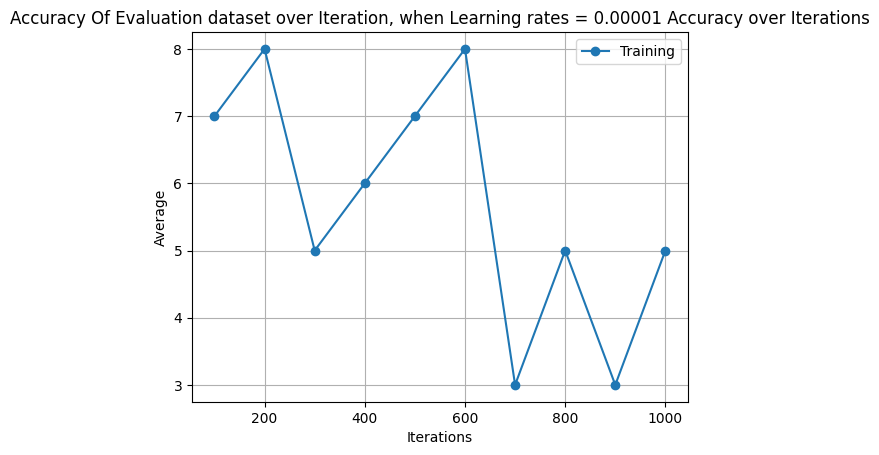

In [ ]:
plot_accuracy(accEval00001, 0.00001, 'Accuracy Of Evaluation dataset over Iteration, when Learning rates = 0.00001')

## Q3

**repeat 2** by plotting the average training loss and the dev loss instead of the accuracy.

The training and the dev losses are computed **by** dividing the loss sums by the number of samples.

In [ ]:
def plot_avg_loss(acc, learning_rate, st):
  plt.plot(range(10), np.array(acc)/X.size, marker='o')
  plt.title('Average ' + st +' Loss over Iterations'+ ' when Learning rates = ' + str(learning_rate))
  plt.xlabel('Iterations')
  plt.ylabel('Average Loss (Cost)')
  plt.grid()
  plt.show()

### LR = 100



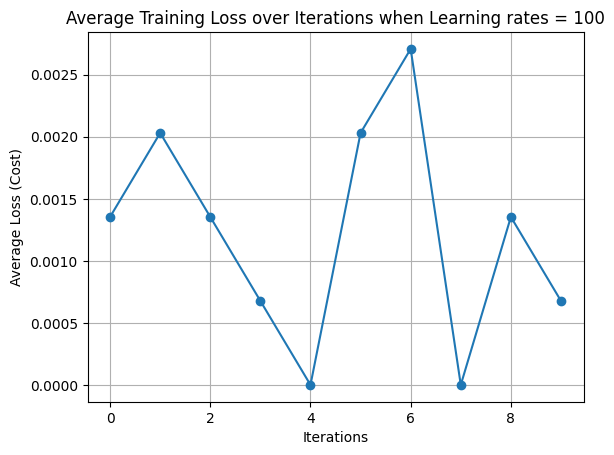

In [ ]:
plot_avg_loss(acc3, 100, 'Training')

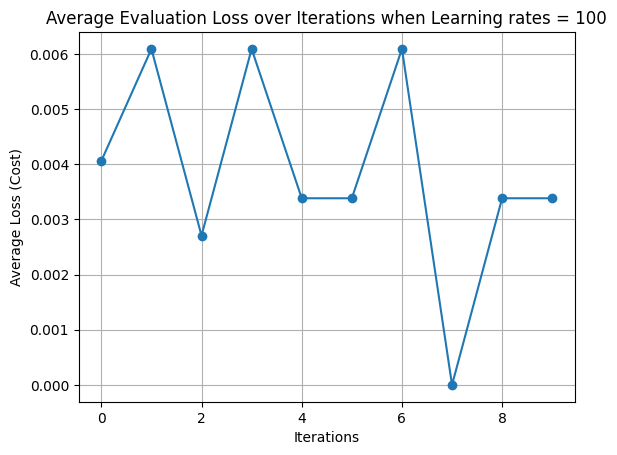

In [ ]:
plot_avg_loss(acc_eval1, 100, 'Evaluation')

### LR = 0.01

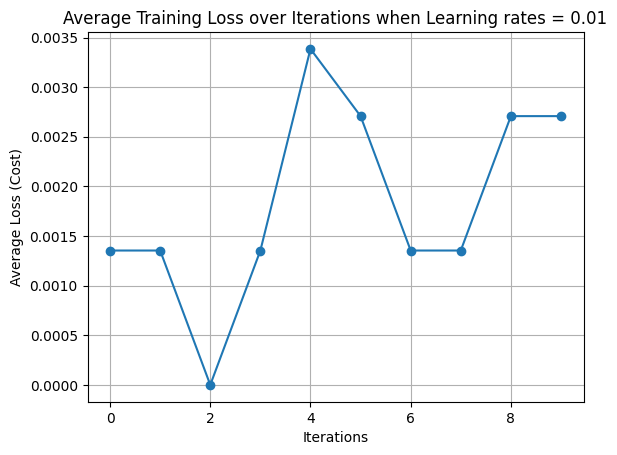

In [ ]:
plot_avg_loss(acc6, 0.01, 'Training')

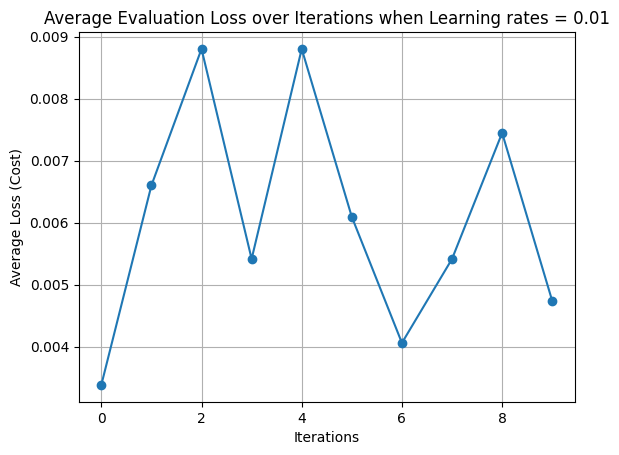

In [ ]:
plot_avg_loss(accEval01, 0.01, 'Evaluation')

### LR = 0.001

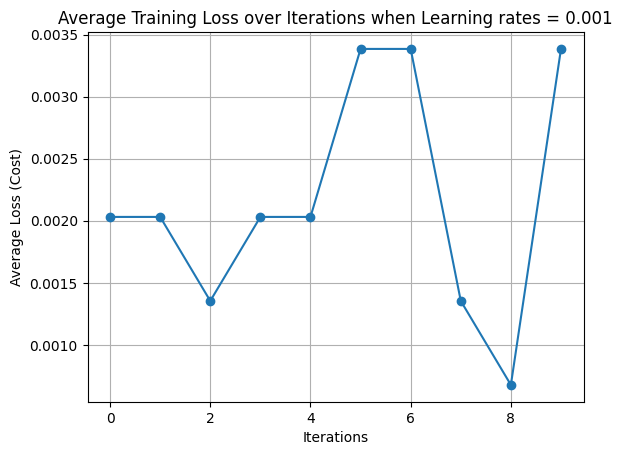

In [ ]:
plot_avg_loss(acc7, 0.001, 'Training')

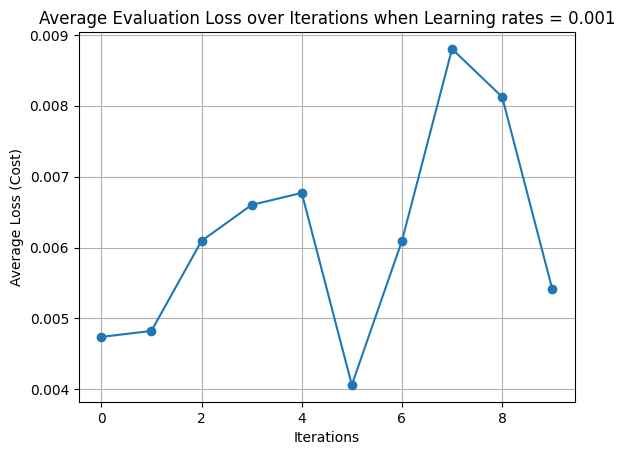

In [ ]:
plot_avg_loss(accEval001, 0.001, 'Evaluation')

### LR = 0.00001

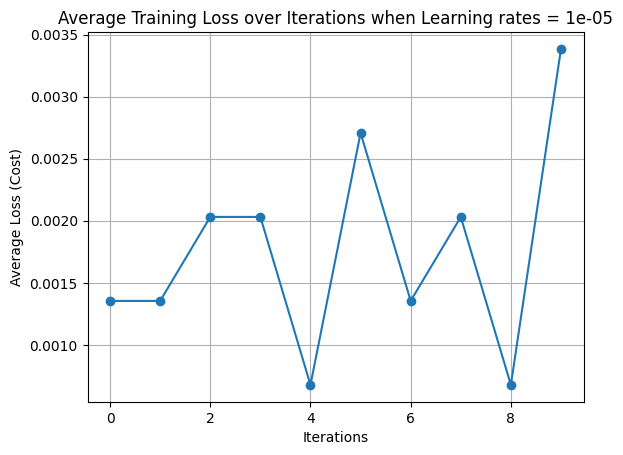

In [ ]:
plot_avg_loss(acc9, 0.00001, 'Training')

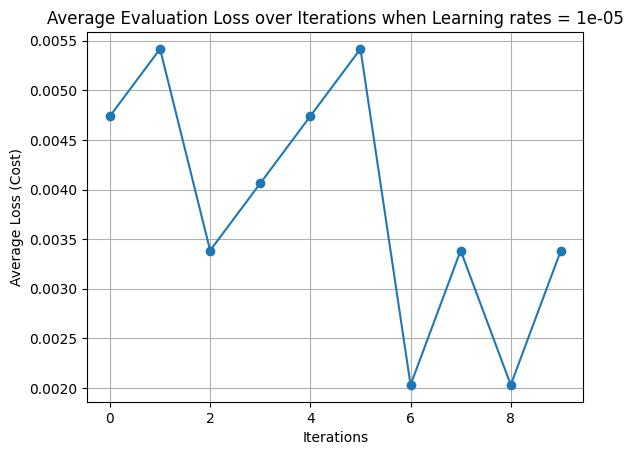

In [ ]:
plot_avg_loss(accEval00001, 0.00001, 'Evaluation')

## Q4

* Plot
 **the validation accuracy** as a function of learning rate (the ones that did not lead to overflow)

* What do you observe? Which learning rate gave you the best results.

* **The y-axis** is the accuracy, **the x-axis** is the learning rate (bar charts or dot charts are good choices for this question).

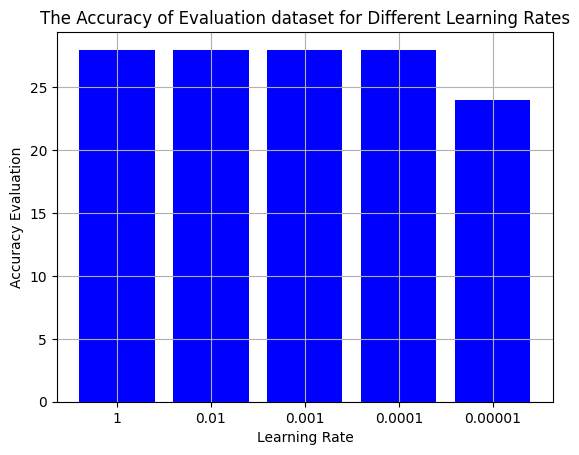

In [ ]:
import matplotlib.pyplot as plt

# Data
acc_eval_list = [max_eval_acc1, max_eval_acc01, max_eval_acc001, max_eval_acc0001,max_eval_acc00001]
learning_rate = ['1', '0.01', '0.001', '0.0001', '0.00001']  # Treat as strings for categories

# Create a bar plot
plt.bar(learning_rate, acc_eval_list, color='blue')
plt.grid(True)

# Add labels and title
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy Evaluation')
plt.title('The Accuracy of Evaluation dataset for Different Learning Rates')


# Show the plot
plt.show()


In [ ]:
acc_eval_list = [max_eval_acc1, max_eval_acc01, max_eval_acc001, max_eval_acc0001,max_eval_acc00001]
acc_list = [max_acc1, max_acc01, max_acc001, max_acc0001,max_acc00001]
print(acc_eval_list)
print(acc_list)

[28.0, 28.0, 28.0, 28.0, 24.0]
[28.0, 28.0, 30.0, 27.0, 25.0]


In [ ]:
print (acc_eval_list , learning_rate)

# which idecate that 0.01 is the best one


[28.0, 28.0, 28.0, 28.0, 24.0] ['1', '0.01', '0.001', '0.0001', '0.00001']


## Q5


Report **the testing accuracy** that corresponds to the best learning rate (you decided from the previous step).




In [ ]:
theta, test_acc, test_max_acc = LR_model(X_test, Y_test, 0.01)
print(theta)

Iteration 0: Cost = 0.21845334763949006
Iteration 100: Cost = 0.12509137674543327
Iteration 200: Cost = 0.12503641054772408
Iteration 300: Cost = 0.12500147510113552
Iteration 400: Cost = 0.12497929717822698
Iteration 500: Cost = 0.1249653392983893
Iteration 600: Cost = 0.12495653857241903
Iteration 700: Cost = 0.1249511652787618
Iteration 800: Cost = 0.12494781457240428
Iteration 900: Cost = 0.1249461083254073
[[0.47336048]
 [0.06552475]]


In [ ]:
print(test_acc)
print(test_max_acc)

[10.0, 8.5, 6.875, 7.75, 8.625, 8.375, 8.0, 8.0, 9.0, 8.75]
23.0


## Q6

1. **Try** different batch sizes (4, 8, 16, 32, 64)
2. **plot** the **validation Accuracy** for these values in one figure, which batch size gave the best performance?

### batch size = 4

In [ ]:

theta, acc_eval_b4, max_val_acc_4b = LR_model(X_Eval, Y_Eval, 0.01,batch_size = 4)
print(theta)

Iteration 0: Cost = 0.13567156682145876
Iteration 100: Cost = 0.12197621380507019
Iteration 200: Cost = 0.12184978568949227
Iteration 300: Cost = 0.12179900730104132
Iteration 400: Cost = 0.12181368007473083
Iteration 500: Cost = 0.12179803817280335
Iteration 600: Cost = 0.12183399042366616
Iteration 700: Cost = 0.1218091023442943
Iteration 800: Cost = 0.12179962520277027
Iteration 900: Cost = 0.12180092141648098
[[0.57467855]
 [0.00834789]]


### batch size = 8

In [ ]:
learning_rate = 0.00001
theta, acc_eval_b8, max_val_acc_8b  = LR_model(X_Eval, Y_Eval, 0.00001, batch_size = 8)
print(theta)

Iteration 0: Cost = 0.28978826563023513
Iteration 100: Cost = 0.26990995296830356
Iteration 200: Cost = 0.25239071866603074
Iteration 300: Cost = 0.23695058749876288
Iteration 400: Cost = 0.22334281334571665
Iteration 500: Cost = 0.21134994383003436
Iteration 600: Cost = 0.2007803046278392
Iteration 700: Cost = 0.19146497465852969
Iteration 800: Cost = 0.18325509232943013
Iteration 900: Cost = 0.1760194870306841
[[0.21523785]
 [0.1090809 ]]


### batch size = 16

In [ ]:

theta, acc_eval_b16, max_val_acc_16b = LR_model(X_Eval, Y_Eval, 0.00001, 16)
print(theta)

Iteration 0: Cost = 0.28994704063296245
[[0.00115855]
 [0.00059031]]


### batch size = 32

In [ ]:
theta, acc_eval_b32, max_val_acc_32b  = LR_model(X_Eval, Y_Eval, 0.00001, 32)
print(theta)

Iteration 0: Cost = 0.28994704035166663
[[0.00231418]
 [0.00117912]]


### batch size = 64

In [ ]:
theta, acc_eval_b64, max_val_acc_64b  = LR_model(X_Eval, Y_Eval, 0.00001, 64)
print(theta)

Iteration 0: Cost = 0.28994704058752213
[[0.00461674]
 [0.00235222]]


### The validation Accuracy with different Batch size plot

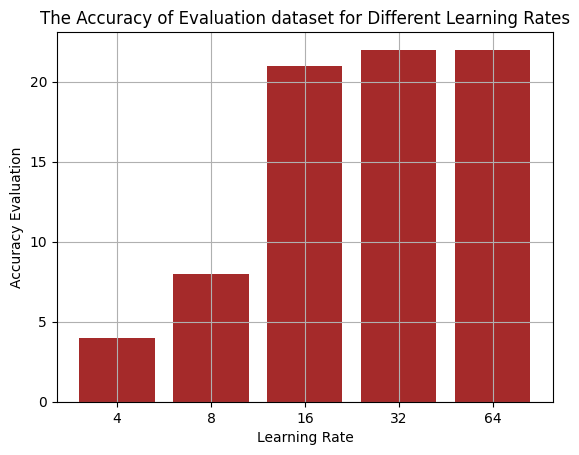

In [ ]:
import matplotlib.pyplot as plt

# Data
acc_eval_list = [max_val_acc_4b, max_val_acc_8b, max_val_acc_16b, max_val_acc_32b, max_val_acc_64b]
learning_rate = ['4', '8', '16', '32', '64']

# Create a bar plot
plt.bar(learning_rate, acc_eval_list, color='brown')
plt.grid(True)

# Add labels and title
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy Evaluation')
plt.title('The Accuracy of Evaluation dataset for Different Learning Rates')


# Show the plot
plt.show()


In [ ]:
acc_eval_list

[4.0, 8.0, 21.0, 22.0, 22.0]

## Q7


* Add L2 regularization to the implementation of gradient decent,
 * what did you add to your implementation?
 * Did adding L2 regularization change to the best validation and testing accuracy you have got?
 * What is the value of 𝜆 you have chosen and why?
 * Do you recommend using regularization?
 * Plot **the training and the validation accuracy** for different values of 𝜆, you the best learning rate value you have obtained to do this part.

In [ ]:
def LR_model (X, Y, learning_rate, num_iterations = 1000, batch_size=32, lambda_reg=0.1): #lambda_reg: Regularization strength (L2 penalty)

  m = Y.size # the size of the dataset
  theta = np.zeros((2,1))

  X = X.values.reshape(-1, 1) #  ensures X becomes a 2D array with shape (1477, 1) instead of a 1D array.
  X = np.hstack((np.ones((X.shape[0], 1)), X))
  Y = Y.values.reshape(-1, 1)


  cost = []
  max_acc = -1e9
  acc = []

  for i in range(num_iterations):
    # Shuffle the data at the start of each epoch

    indices = np.arange(m)
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]

    for start in range(0, m, batch_size):
      end = start + batch_size
      X_batch = X[start:end]  # Current batch of features
      Y_batch = Y[start:end]  # Current batch of targets


      # Predictions for the current batch and calculate current accuravy
      y_pred = np.dot(X_batch, theta)
      current_acc = accuracy(Y_batch, y_pred)
      max_acc = max(max_acc, current_acc)


      # Compute the cost with L2 regularization (Ridge)
      cost_batch = (1 / (2 * batch_size)) * np.sum(np.square(y_pred - Y_batch)) + (lambda_reg / (2 * batch_size)) * np.sum(np.square(theta[1:]))  # Regularization on theta[1:]

      # Compute the gradient with L2 regularization (Ridge)
      d_theta = (1 / batch_size) * np.dot(X_batch.T, (y_pred - Y_batch)) + (lambda_reg / batch_size) * np.vstack([0, theta[1:]])  # Regularization on theta[1:]


      # Update weights
      theta = theta - learning_rate * d_theta

    # Log cost, accuracy every 100 iterations
    if i % 100 == 0:
      total_cost = (1 / (2 * m)) * np.sum(np.square(np.dot(X, theta) - Y)) + (lambda_reg / (2 * m)) * np.sum(np.square(theta[1:]))  # Regularization term
      print(f"Iteration {i}: Cost = {total_cost}")
      cost.append(total_cost)
      acc.append(current_acc)

  # Append the final loss
  final_cost = (1 / (2 * m)) * np.sum(np.square(np.dot(X, theta) - Y))
  cost.append(final_cost)

  return theta, acc, max_acc

In [ ]:
LR_model(X_Eval,Y_Eval,.001,lambda_reg = 100)

Iteration 0: Cost = 0.284804403760832
Iteration 100: Cost = 0.1350898200922344
Iteration 200: Cost = 0.1231786927573609
Iteration 300: Cost = 0.12194349472344522
Iteration 400: Cost = 0.12181467801425858
Iteration 500: Cost = 0.12180140448647021
Iteration 600: Cost = 0.12180005382481857
Iteration 700: Cost = 0.12179994359303482
Iteration 800: Cost = 0.12179994212233396
Iteration 900: Cost = 0.12179994711522618


(array([[5.79924406e-01],
        [1.27903126e-04]]),
 [5.0, 5.0, 12.0, 8.0, 10.0, 11.0, 11.0, 13.0, 8.0, 11.0],
 28.0)

In [ ]:
LR_model(X_test,Y_test,.001,lambda_reg = 100)

Iteration 0: Cost = 0.2497276971282971
Iteration 100: Cost = 0.13511175557514576
Iteration 200: Cost = 0.1260313289428993
Iteration 300: Cost = 0.12508203283467192
Iteration 400: Cost = 0.12498241754633471
Iteration 500: Cost = 0.1249724655149734
Iteration 600: Cost = 0.1249715867191731
Iteration 700: Cost = 0.12497153592141551
Iteration 800: Cost = 0.12497154509191544
Iteration 900: Cost = 0.12497154847060875


(array([[5.07329812e-01],
        [3.18777286e-04]]),
 [2.0, 6.0, 9.0, 5.0, 7.0, 4.0, 10.0, 11.0, 8.0, 8.0],
 27.0)

In [ ]:
LR_model(X_Eval,Y_Eval,.001,lambda_reg = 1)

Iteration 0: Cost = 0.2847839371126413
Iteration 100: Cost = 0.12936747658460038
Iteration 200: Cost = 0.12262549796360225
Iteration 300: Cost = 0.12225493735884875
Iteration 400: Cost = 0.12218786390291918
Iteration 500: Cost = 0.12214431275242134
Iteration 600: Cost = 0.12210702985842531
Iteration 700: Cost = 0.12207391370171009
Iteration 800: Cost = 0.12204424112122074
Iteration 900: Cost = 0.1220176546272432


(array([[0.50330159],
        [0.14466421]]),
 [6.0, 8.0, 8.0, 8.0, 10.0, 9.0, 8.0, 8.0, 11.0, 11.0],
 28.0)

In [ ]:
LR_model(X_Eval,Y_Eval,.001,lambda_reg = .00001)

Iteration 0: Cost = 0.28478222610130016
Iteration 100: Cost = 0.12917236922216982
Iteration 200: Cost = 0.12255284614364909
Iteration 300: Cost = 0.122254180633012
Iteration 400: Cost = 0.12222383122674016
Iteration 500: Cost = 0.12220561834640016
Iteration 600: Cost = 0.12218861555625185
Iteration 700: Cost = 0.12217233802467653
Iteration 800: Cost = 0.12215673563909929
Iteration 900: Cost = 0.12214177950503273


(array([[0.4790273 ],
        [0.19539759]]),
 [6.0, 7.125, 8.0, 6.25, 11.0, 7.0, 11.0, 11.0, 9.75, 8.0],
 28.0)

In [ ]:
LR_model(X_Eval,Y_Eval,.001,lambda_reg = .001)

Iteration 0: Cost = 0.28478334795601185
Iteration 100: Cost = 0.129171085237625
Iteration 200: Cost = 0.12255342860391379
Iteration 300: Cost = 0.1222542226869214
Iteration 400: Cost = 0.1222237920922361
Iteration 500: Cost = 0.12220554325410102
Iteration 600: Cost = 0.12218851864788631
Iteration 700: Cost = 0.12217221916185451
Iteration 800: Cost = 0.12215659618278824
Iteration 900: Cost = 0.12214162223975956


(array([[0.47906801],
        [0.19534412]]),
 [9.0, 10.0, 7.25, 9.0, 13.0, 12.375, 10.625, 8.0, 12.0, 7.0],
 27.0)

## Q8

train a model without data normalization:
* does it work? Is it easy to train? Did you need more iterations? Explain your observation? Which rate of learning works the best for unnormalized data?

* **(Do similar plot for 3 learning rate values of your choice like the plots in part Q1.)**
